# Bayesian AB Test Code  < ref: Will Kurt>  2024-06 ~ 2024-07


In [2]:
# Dash Report

# composed of dash components (input), plotly graph (output), callback (interactivity function)

import pandas as pd
import plotly.express as px

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 

from scipy import stats as stats
import plotly.figure_factory as ff
import numpy as np
import random 

random.seed(10)

warnings.filterwarnings('ignore')

In [69]:
my_style = {
    'font-family': 'Arial' # 'Noto Sans' - saving the font to matlab font manager doesn't make it available for CSS to use. 
}

# -------------------------------------------
# App layout
app = JupyterDash(__name__)


app.layout = html.Div([
    html.H2("Bayesian A/B Test Calculator", style = my_style),
    html.H3("Input", style = my_style),
    html.Div([ # first input
        "What was your initial estimate of conversion rate before the experiment? : ",
        dcc.Input(id='prior', value='0.5', type='number')
    ], style = my_style),
    html.Br(),
    html.Div([ # first input
        "How strongly do you believe in the probability? : ",
        dcc.RadioItems(id='prior_strength',
                      options=[
                          {'label':'Weak', 'value': '10'},
                          {'label':'Medium', 'value': '100'},
                          {'label':'Strong', 'value': '1000'},
                      ], 
                      value = '100')
    ], style = my_style),
        html.Br(),
    html.Div([ # second input
        "Input Control Group (A) Sample Size: ",
        dcc.Input(id='control_size', value='1', type='number')
    ], style = my_style),
    html.Div([ # thrid input
        "Input Control Group (A) Conversion: ",
        dcc.Input(id='control_convert', value='1', type='number')
    ], style = my_style),
    html.Div([ # fourth input
        "Input Challenge Group (B) Sample Size: ",
        dcc.Input(id='challenge_size', value='1', type='number')
    ], style = my_style),
    html.Div([ # fifth input
        "Input Challenge Group (B) Conversion: ",
        dcc.Input(id='challenge_convert', value='1', type='number')
    ], style = my_style),
    html.Br(),
    html.Div([ # first input
    "At how much improvement will you accept the Challenge group? : ",
    dcc.RadioItems(id='acceptance_ratio',
                  options=[
                      {'label':'0% or bettter', 'value': '0'},
                      {'label':'0.2% or better', 'value': '0.002'},
                      {'label':'0.5% or better', 'value': '0.005'},
                      {'label':'1.0% or better', 'value': '0.01'},
                      {'label':'I don\'t know', 'value': 'None'},
                  ], 
                  value = '0')
    ], style = my_style),
    html.Br(),
    html.H3("Summary", style = my_style),
    html.Div(id='summary_output', children=[], style = my_style), # render text output
    html.H3("Analysis", style = my_style),
    html.Div(id='text_output', children=[], style = my_style), # render text output
    html.Br(),
    dcc.Graph(id='sample_theoretical_plot', figure={}, style = my_style), # render plot output 
    html.Br(),
    html.Div(id='text_output2', children=[], style = my_style), # render text output # text output goes after 1st graph
    html.Br(),
    dcc.Graph(id='monte_carlo_hist', figure={}, style = my_style), # render plot output 
    html.Br(),
    html.Div(id='text_output3', children=[], style = my_style), 
    html.Br(),
    dcc.Graph(id='monte_carlo_ecdf', figure={}, style = my_style), # render plot output
])

# ----------------------------------------------
# Connect the Plotly graphs with Dash Componentsx

@app.callback(
    [
    Output(component_id='summary_output', component_property='children'),
    Output(component_id='text_output', component_property='children'),# Updating Children: The returned strings from the callback are assigned to the children properties of the html.Div components with IDs output1 and output2. This updates the content inside these div element
    Output(component_id='text_output2', component_property='children'),
     Output(component_id='text_output3', component_property='children')],
    [Input(component_id='prior', component_property='value'), # order determines variable order into update_output_div function
     Input(component_id='prior_strength',component_property='value'),
    Input(component_id = 'control_size', component_property='value'),
    Input(component_id = 'control_convert', component_property='value'),
    Input(component_id = 'challenge_size', component_property='value'),
    Input(component_id = 'challenge_convert', component_property='value'),
    Input(component_id = 'acceptance_ratio', component_property='value')]
)
def update_output_div(prior,prior_strength, control_size, control_convert, challenge_size, challenge_convert, acceptance_ratio):
    rng = np.random.RandomState(10)
    
    # Convert input values from string to float
    prior = float(prior) if prior is not None else 1.0  # somehow, if not ifelse statement, the variable still not recognised as float, instead str.
    prior_strength = float(prior_strength) if prior_strength is not None else 1.0 
    control_size = float(control_size) if control_size is not None else 1.0
    control_convert = float(control_convert) if control_convert is not None else 1.0
    challenge_size = float(challenge_size) if challenge_size is not None else 1.0
    challenge_convert = float(challenge_convert) if challenge_convert is not None else 1.0
    # acceptance_ratio = float(acceptance_ratio) if acceptance_ratio is not None else 0.0
    
    total = control_size+challenge_size
    control_cr = control_convert/control_size
    challenge_cr = challenge_convert/challenge_size
    
    initial_winner= 'control' if control_cr >= challenge_cr else 'challenge'
    initial_loser = 'control' if control_cr < challenge_cr else 'challenge'
    
    if initial_winner == 'challenge': 
        initial_comment = 'outperforms'
    else:
        initial_comment = 'underperforms'
        
    
    prior_a = prior*prior_strength
    prior_b = prior_strength - prior_a
    
    control_a = control_convert
    control_b = control_size - control_convert
    
    challenge_a = challenge_convert
    challenge_b = challenge_size - challenge_convert
    
    trials = 100000
    
    post_control_samples = stats.beta((control_a+prior_a), (control_b+prior_b)).rvs(trials, random_state=rng)
    post_chllng_samples =  stats.beta((challenge_a+prior_a),(challenge_b+prior_b)).rvs(trials,random_state= rng)
    
    post_ratio = post_chllng_samples / post_control_samples
    sorted_post_ratio = np.sort(post_ratio)
    post_ecdf = np.arange(1,len(sorted_post_ratio)+1)/len(sorted_post_ratio)
    
    
    post_ratio_median = np.median(post_chllng_samples/post_control_samples)
    
    # ecdf commentary 
                                  
    post_df = pd.DataFrame({
        'sorted_post_ratio': sorted_post_ratio,
        'post_ecdf': post_ecdf
    })                          
    
    # find post_ecdf equivalent to post_ratio ==1 
    
    if post_df.loc[post_df['sorted_post_ratio'] <= 1].empty:
        post_ecdf_one = post_df.loc[post_df['sorted_post_ratio']>=1].iloc[0]['post_ecdf'] # error found: alternative is post_df.loc[post_df['sorted_post_ratio']>=1].iloc[0] but the if post_ratio does not reach 1, then creates error in iloc function as there is no row returned. Inverse is the same where control cr << challenge cr.
    else: 
        post_ecdf_one = post_df.loc[post_df['sorted_post_ratio']<=1].iloc[-1]['post_ecdf']
        
    if post_df.loc[post_df['sorted_post_ratio'] <= 1.1].empty:
        post_ecdf_tenperc = post_df.loc[post_df['sorted_post_ratio']>=1.1].iloc[0]['post_ecdf']
    else:
        post_ecdf_tenperc = post_df.loc[post_df['sorted_post_ratio']<=1.1].iloc[-1]['post_ecdf']        
    
    post_ratio_p25 = post_df.loc[post_df['post_ecdf']<=0.25].iloc[-1]['sorted_post_ratio']
    
    post_ratio_p75 = post_df.loc[post_df['post_ecdf']<=0.75].iloc[-1]['sorted_post_ratio']
                                  
                                  
    # Calculate probability of challenge being superior
    if initial_winner == 'challenge':
        prob_superior = sum(post_chllng_samples >= post_control_samples) / trials
    else:
        prob_superior = sum(post_control_samples >= post_chllng_samples) / trials
        
        
    if prob_superior < 0.8:
        prob_superior_comment = 'low'
    else: 
        prob_superior_comment = 'high'
        
    # conclude A/B test
    # (as input)at what % improvement, will you accept the challenge?  {0%, 0.2%, 0.5%, 1%, don't know}
    # (as output), according to your acceptance criteria, there is y% chance that challenge will outperform by x% or better. This is considered relatively {prob_superior_comment} chance. 
    # (as output), applying general guidance, there is y% chance that challenge will outperform the control. 
    # cont'd - Please review the probability curve to understand the likelihood at different magnitude of improvement.'
    
    if acceptance_ratio != 'None':
        acceptance_ratio = float(acceptance_ratio)
        if post_df.loc[post_df['sorted_post_ratio'] <= (1+acceptance_ratio)].empty: 
            post_ecdf_x = post_df.loc[post_df['sorted_post_ratio']>=(1+acceptance_ratio)].iloc[0]['post_ecdf']
        else: 
            post_ecdf_x = post_df.loc[post_df['sorted_post_ratio']<=(1+acceptance_ratio)].iloc[-1]['post_ecdf']
            
        conclusion_text = f'According to your acceptance criteria, there is {round((1-post_ecdf_x)*100,1)}% that challenge will outperform the control by {acceptance_ratio*100}% or more. This is considered relatively {prob_superior_comment} chance.'
    else:
        if post_df.loc[post_df['sorted_post_ratio'] <= 1].empty: 
            post_ecdf_x = post_df.loc[post_df['sorted_post_ratio']>=(1)].iloc[0]['post_ecdf']
        else:
            post_ecdf_x = post_df.loc[post_df['sorted_post_ratio']<=(1)].iloc[-1]['post_ecdf']
               
        conclusion_text = f'Applying general guidance, there is {round((1-post_ecdf_x)*100,1)}% chance that challenge will at least be same or better than the control. Please review the probability curve to understand the likelihood at different magnitude of improvement.' 
    
    return [
            conclusion_text
            ],[
            f'Your given prior probability is : {prior*100}%',
            html.Br(),
            f'Total test size is {int(total)}. Control size is {int(control_size)} and Challenge size is {int(challenge_size)}.',
            html.Br(),
            f'Control conversion rate is: {round(control_cr * 100,1)}%',
            html.Br(),
            f'Challenge conversion rate is: {round(challenge_cr * 100,1)}%',
            html.Br(),
            html.Br(),
            f'Initially, it appears the challenge group {initial_comment} by {round((challenge_cr - control_cr)*100,1)}p.p.', 
            html.Br(),
            html.Br(),
            f' However, the true conversion rate can be a range of possible values. How likely is that {initial_winner} is actually the better variant and by how much?',
            html.Br(),
            html.Br(),
            f'We can estimate possible values by fitting distribution curves. Assume all samplings follow beta distribution. Then we can compare the range of possible conversion rates and overlap between those possibilities.'
            
           ], [  # second text can add elements to the return list
            f'Using Monte-Carlo simulation, we sample {trials} times from each distribution modeled here.',
            html.Br(),
            f'According to the simulation, the actual likelihood of {initial_winner} > {initial_loser}  is {round(prob_superior*100,1)}%. At this level, the likelihood is quite {prob_superior_comment}.',
            html.Br(),
            f'Below is the histogram of challenge / control ratio. If the distribution is skewed over 1, it means challenge likely to outperforms. If the distribution is skewed under 1, it meanse control is likely better.',
            html.Br(),
            f'From the histogram, it is seen that most likely case is about {round((post_ratio_median-1)*100,1)}% improvement over control but we can see an entire range of values.',
            html.Br(),
            ], [ # third text
            f'The Cumulative Distribution Function (CDF) adds more useful for reasoning about our results.',
            html.Br(),
            f'There is just {round((1-post_ecdf_one)*100,1)}% chance that challenge is better. We can also see that there is about {round((1-post_ecdf_tenperc)*100,1)}% chance that challenge is 10% or more improvement over control.',
            html.Br(),
            f'The chance that challenge is {round((post_ratio_p25-1)*100,1)}% or worse is roughly the same that it\'s {round((post_ratio_p75-1)*100,1)}% or better.'
            ]

            
# Additional callback # can add multiple outputs figs or texts, just return that many variables at the end
@app.callback(
    [Output(component_id='sample_theoretical_plot', component_property='figure'),
     Output(component_id='monte_carlo_hist', component_property='figure'),
    Output(component_id='monte_carlo_ecdf', component_property='figure')],   
    [Input(component_id='prior', component_property='value'),
     Input(component_id='prior_strength',component_property='value'),
     Input(component_id='control_size', component_property='value'),
     Input(component_id='control_convert', component_property='value'),
     Input(component_id='challenge_size', component_property='value'),
    Input(component_id = 'challenge_convert', component_property='value'),
    Input(component_id = 'acceptance_ratio', component_property='value')]
)
def update_graph(prior, prior_strength, control_size, control_convert, challenge_size, challenge_convert,acceptance_ratio):
    rng = np.random.RandomState(10)
    
    # Convert input values from string to float
    prior = float(prior) if prior is not None else 1.0  # somehow, if not ifelse statement, the variable still not recognised as float, instead str.
    prior_strength = float(prior_strength) if prior_strength is not None else 1.0 
    control_size = float(control_size) if control_size is not None else 1.0
    control_convert = float(control_convert) if control_convert is not None else 1.0
    challenge_size = float(challenge_size) if challenge_size is not None else 1.0
    challenge_convert = float(challenge_convert) if challenge_convert is not None else 1.0
    # acceptance_ratio = float(acceptance_ratio) if acceptance_ratio is not None else 0.0
    
    prior_a = prior*prior_strength
    prior_b = prior_strength - prior_a
    
    control_a = control_convert
    control_b = control_size - control_convert
    
    challenge_a = challenge_convert
    challenge_b = challenge_size - challenge_convert
    
    trials = 1000
    
    post_control_samples = stats.beta((control_a+prior_a), (control_b+prior_b)).rvs(trials, random_state= rng)
    post_chllng_samples =  stats.beta((challenge_a+prior_a),(challenge_b+prior_b)).rvs(trials,random_state= rng)
    
    post_ratio = post_chllng_samples / post_control_samples
    sorted_post_ratio = np.sort(post_ratio)
    post_ecdf = np.arange(1,len(sorted_post_ratio)+1)/len(sorted_post_ratio)
    
    prob_chllng_super = sum(post_chllng_samples > post_control_samples)/trials

    
    fig = go.Figure()
    x = np.linspace(0, 1, 1000)
    prior_pdf = stats.beta(prior_a, prior_b).pdf(x)
    control_pdf = stats.beta(control_a, control_b).pdf(x)
    challenge_pdf = stats.beta(challenge_a, challenge_b).pdf(x) # not sure if this will allow % calculation later. 
    fig.add_trace(go.Scatter(x=x, y = prior_pdf, mode='lines',name = 'prior PDF'))
    fig.add_trace(go.Scatter(x=x, y=control_pdf, mode='lines', name='control PDF')) # confirmed the AUC = 1
    fig.add_trace(go.Scatter(x=x, y = challenge_pdf, mode = 'lines', name = 'challenge PDF'))
    fig.update_layout(
        title= 'Prior Distribution',
        xaxis_title='conversion rate',
        yaxis_title='probability density')
    
    fig_mc = go.Figure()
    data = go.Histogram(x = post_chllng_samples/post_control_samples)
    fig_mc.add_trace(data)
    fig_mc.update_layout(
        title='Posterior Ratio Histogram',
        xaxis_title='challenge sample / control sample',
        yaxis_title='frequency')
    
    fig_ecdf = go.Figure()
    fig_ecdf.add_trace(go.Scatter(x=sorted_post_ratio, y=post_ecdf, mode='lines', name='posterior ratio ecdf'))
    fig_ecdf.update_layout(
        title='Posterior Ratio ECDF',
        xaxis_title= 'challenge sample / control sample',
        yaxis_title='cumulative probability')
    
    return fig,fig_mc, fig_ecdf
    

# ----------------------------------------------
# this runs when app is reset, run from # App layout 
if __name__ == '__main__':
        app.run_server(port=2223,mode='inline') #mode inline or new browser tab
     


In [38]:
(0.536-0.418)*17.8*0.5

1.0502000000000005

In [57]:
#### code for kde curve on probability parameters, monte carlo simulation vs theoretical pdf
#### I can observe monte carlo convering to the theoretical pdf as trial increases.
### reference: https://chatgpt.com/c/7c42439d-87fa-4ee3-93b6-f2a4488a620f (chatGPT)

from scipy import stats as stats
import plotly.figure_factory as ff
import numpy as np


# given alpha & beta of beta distribution(s)
# try, plotting two pdfs, control vs challenge 

alpha = 3 # still determines the strength, the  sharpness of distribution
beta = 7

trials = 100 # as trials increase, in conforms to the theoretical PDF curve. , as randomly created, n trials in monte carlo is not same as n spacing in theoretical pdfs
#PDF y value need not <1 as long as the area under the curve (AUC) < 1

a_samples = stats.beta(alpha, beta).rvs(trials)
b_samples =  stats.beta(alpha,beta).rvs(trials)

#display(a_samples) 


fig = go.Figure()

# Create distplot, y = estimated pdf of the data 
fig = ff.create_distplot([a_samples], group_labels=['Monte Carlo Beta Distribution'], bin_size=0.05,show_hist = False, show_rug = False, curve_type= 'kde')

#fig.add_trace(data)

# Add the theoretical PDF (but it's still simulation, not theoretical )
x = np.linspace(0, 1, 100000) # as spacing gets smaller, the smoother the plot, determines the conformation to the theoretical pdf
pdf = stats.beta(alpha, beta).pdf(x) # research on this function 
data = go.Scatter(x=x, y=pdf, mode='lines', name='Theoretical PDF')
fig.add_trace(data)



# Show plot
fig.show()

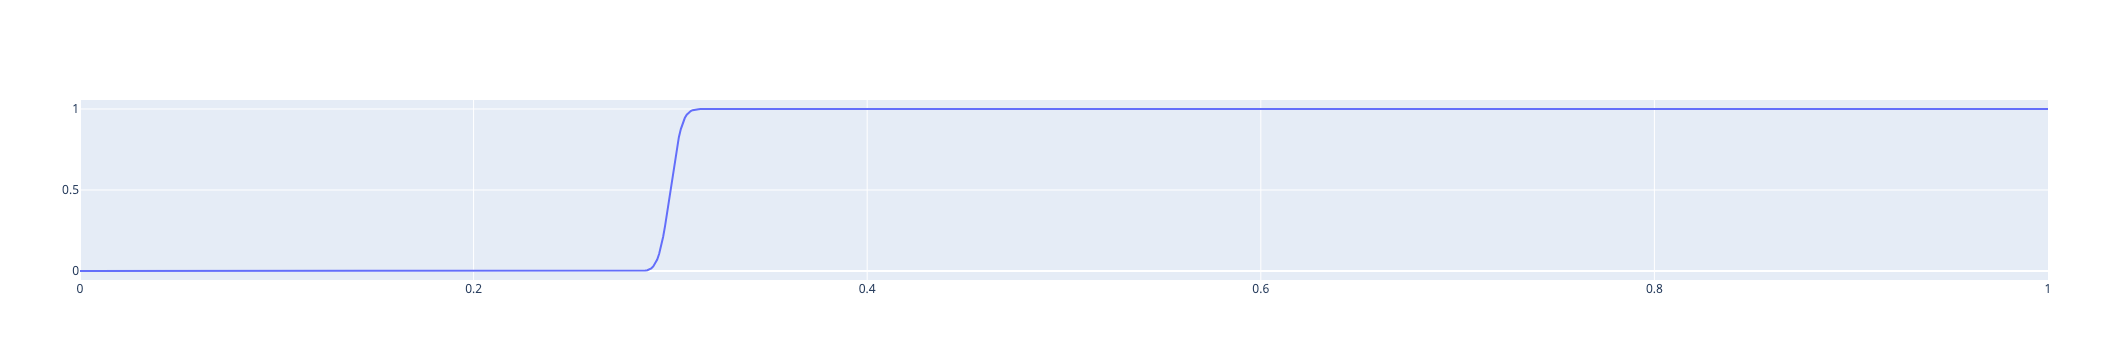

In [183]:
#### code for ecdf curve
#### reference: https://plotly.com/python/ecdf-plots/


### THEORETICAL ECDF 
fig = go.Figure()

ecdf = stats.beta(alpha, beta).cdf(x) # 걍 시도해봤는데 있는 function 이네! 

data = go.Scatter(x=x, y=ecdf, mode='lines', name='Theoretical ECDF')

fig.add_trace(data)
fig.show()


#px.ecdf(df, x="total_bill", color="sex", facet_row="time", facet_col="day")




In [ ]:
display(pdf,10)

### REFERENCE

1. plotly distplot - https://plotly.com/python/distplot/
2. publishing on server - https://stackoverflow.com/questions/65436835/share-plotly-dash-project (kaggle)
https://devcenter.heroku.com/articles/getting-started-with-python#next-steps (heroku)
https://dash.plotly.com/deployment
https://towardsdatascience.com/the-easiest-way-to-deploy-your-dash-app-for-free-f92c575bb69e (python anywhere)



### LIST OF TO DO 

* return two outputs DONE
* return plotly chart DONE
* return text outputs AND plotly chart DONE
* plot pdf curve # DONE 
* return pdf curve in Dash # DONE
* add relative comparison statement DONE
* add plot cdf curve DONE
* return ecdf curve in Dash DONE
* change font  to Roboto DONE
* 문제는 true probability 를 구할때 theoretical pdf 를 쓰냐 아니면 monte carlo 를 쓰냐 
* theoretical 은 걍 sample outcome 과 같은 probability 아님? 확인해보면 되지
* create online access - if I export the file to html, the dash works (only for my laptop!) else pythonanywhere else shiny for python as backup
* add seed for random generation so numeric & plot coincide DONE
* find median of ratio plot, comment "x% better" DONE
* add commentary for ecdf
* boldify, stylise the calculator
#-------- finish till here in w27

In [ ]:
    x = np.linspace(0, 1, 1000)

In [109]:
data



Scatter({
    'mode': 'lines',
    'name': 'Theoretical PDF',
    'x': array([0.0000000e+00, 1.0000001e-07, 2.0000002e-07, ..., 9.9999980e-01,
                9.9999990e-01, 1.0000000e+00]),
    'y': array([0.00000000e+00, 1.78918801e-09, 7.15670267e-09, ..., 0.00000000e+00,
                0.00000000e+00, 0.00000000e+00])
})

In [44]:
    trials = 1000
    
    post_control_samples = stats.beta((99), (100)).rvs(trials)
    post_chllng_samples =  stats.beta((1),(1000)).rvs(trials)
    
    post_ratio = post_chllng_samples / post_control_samples
    sorted_post_ratio = np.sort(post_ratio)
    post_ecdf = np.arange(1,len(sorted_post_ratio)+1)/len(sorted_post_ratio)
    
    post_df = pd.DataFrame({
        'sorted_post_ratio':sorted_post_ratio,
        'post_ecdf': post_ecdf
    })
    
display(post_df)

post_df.loc[post_df['sorted_post_ratio']<=1].iloc[-1]['post_ecdf']

,sorted_post_ratio,post_ecdf
0,0.000004,0.001
1,0.000008,0.002
2,0.000012,0.003
3,0.000014,0.004
4,0.000016,0.005
...,...,...
995,0.010650,0.996
996,0.010783,0.997
997,0.011414,0.998
998,0.013096,0.999


1.0